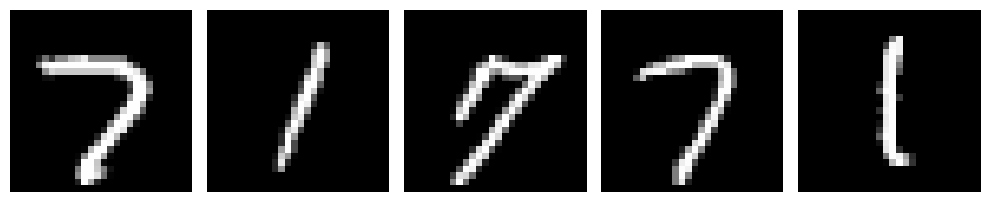

In [12]:
# Import necessary libraries and the MNIST dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from zuko.utils import odeint

# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Sample 5 images from the dataset
num_samples = 5
indices = torch.randperm(len(train_dataset))[:num_samples]
samples = [train_dataset[i][0] for i in indices]  # Get the images

# Visualize the samples
fig, axes = plt.subplots(1, num_samples, figsize=(10, 4))
for i, ax in enumerate(axes):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Define time embedding and the flow model architecture

class ZeroToOneTimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.register_buffer('freqs', torch.arange(1, dim // 2 + 1) * torch.pi)

    def forward(self, t):
        # t: (# points in the grid,) 

        # ... list all the dimensions before the last one, None adds a new dimension
        emb = self.freqs * t[..., None] # (num points in the gris (10x10), dim // 2 + 1)) by broadcasting
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1) # (num points in the grid, (dim // 2 + 1) * 2)
        return emb


class FlowNeuralNetwork(nn.Module):
    def __init__(self, n_features, time_embedding_size=8, n_blocks=20):
        super().__init__()
        self.time_embedding = ZeroToOneTimeEmbedding(time_embedding_size)
        hidden_size = n_features + time_embedding_size
        blocks = []
        for _ in range(n_blocks):
            blocks.append(nn.Sequential(
                nn.BatchNorm1d(hidden_size),
                nn.Linear(hidden_size, hidden_size),
                nn.SiLU(),
            ))
        self.blocks = nn.ModuleList(blocks)
        self.final = nn.Linear(hidden_size, n_features)


    def forward(self, X, time):
        # x: (num points, num features) (100,2)
        # time: (num points,) (100,), all with the same time value

        X = torch.cat([X, self.time_embedding(time)], axis=1) # (num points (100), num features + time_embedding_size)
        for block in self.blocks:
            X = X + block(X)
        X = self.final(X)
        return X
    
# Instantiate the model
n_features = 28 * 28
flow_model = FlowNeuralNetwork(n_features)

In [9]:
#The conditional flow matching loss works as follows:

# We are given some data points
# For every data point we randomly choose a time value t between 0 and 1
# We calculate x_t, which is a linear interpolation between gaussian noise and the data points
# We define the optimal flow as pointing from the sampled noise straight at the corresponding data points
# The loss is the mean square difference between the optimal flow and what the flow model outputs

def conditional_flow_matching_loss(flow_model, x):
    sigma_min = 1e-4 # To avoid numerical instability
    t = torch.rand(x.shape[0], device=x.device) # generate random time values for each point in the dataset
    noise = torch.randn_like(x) # generate noise for each point in the dataset, with zero mean and unit variance
    
    # x_t at time zero has more noise, the more time passes, the less noise it has and it is closer to the dataset 
    
    # (1 − ( 1 − σmin​) ⋅ t) ⋅ noise: This term scales the noise by a factor that depends on t. When t is small, 
    # this factor is close to 1, meaning the noise has a significant impact on x_t​. As t increases, 
    # the factor decreases, reducing the influence of noise.

    #t ⋅ x: This term scales the original data x by t. When t is small, this term has little impact, but as t increases, 
    # this term approaches x, making x_t​ more similar to x.

    x_t = (1 - (1 - sigma_min) * t[:, None]) * noise + t[:, None] * x
    
    
    # This represents the "ideal" transformation that the model should learn to match. 
    # It essentially tells the model how to adjust from the noisy data x_t​ back to the original data x.
    optimal_flow = x - (1 - sigma_min) * noise

    predicted_flow = flow_model(x_t, time=t)

    loss = (predicted_flow - optimal_flow).square().mean()
    return loss

In [10]:
# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
flow_model = flow_model.to(device)
optimizer = optim.Adam(flow_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 50

for epoch in range(num_epochs):
    flow_model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch in progress_bar:
        x, _ = batch # x: (batch_size, 1, 28, 28), _: (batch_size,) y labels not used
        x = x.view(x.size(0), -1).to(device)
        optimizer.zero_grad()
        loss = conditional_flow_matching_loss(flow_model, x)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        average_loss = running_loss / (len(progress_bar) + 1)
        progress_bar.set_postfix(loss=f"{average_loss:.4f}")
    
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
    scheduler.step()  # Adjust learning rate

Epoch [1/50], Loss: 1.0113


Epoch [2/50], Loss: 0.7740


Epoch [3/50], Loss: 0.6872


Epoch [4/50], Loss: 0.6248


Epoch [5/50], Loss: 0.5788


Epoch [6/50], Loss: 0.5447


Epoch [7/50], Loss: 0.5185


Epoch [8/50], Loss: 0.4978


Epoch [9/50], Loss: 0.4848


Epoch [10/50], Loss: 0.4723


Epoch [11/50], Loss: 0.4428


Epoch [12/50], Loss: 0.4341


Epoch [13/50], Loss: 0.4323


Epoch [14/50], Loss: 0.4284


Epoch [15/50], Loss: 0.4252


Epoch [16/50], Loss: 0.4238


Epoch [17/50], Loss: 0.4209


Epoch [18/50], Loss: 0.4175


Epoch [19/50], Loss: 0.4137


Epoch [20/50], Loss: 0.4131


Epoch [21/50], Loss: 0.4005


Epoch [22/50], Loss: 0.3970


Epoch [23/50], Loss: 0.3947


Epoch [24/50], Loss: 0.3939


Epoch [25/50], Loss: 0.3922


Epoch [26/50], Loss: 0.3907


Epoch [27/50], Loss: 0.3904


Epoch [28/50], Loss: 0.3890


Epoch [29/50], Loss: 0.3892


Epoch [30/50], Loss: 0.3869


Epoch [31/50], Loss: 0.3806


Epoch [32/50], Loss: 0.3777


Epoch [33/50], Loss: 0.3780


Epoch [34/50], Loss: 0.3765


Epoch [35/50], Loss: 0.3761


Epoch [36/50], Loss: 0.3741


Epoch [37/50], Loss: 0.3758


Epoch [38/50], Loss: 0.3746


Epoch [39/50], Loss: 0.3733


Epoch [40/50], Loss: 0.3718


Epoch [41/50], Loss: 0.3698


Epoch [42/50], Loss: 0.3686


Epoch [43/50], Loss: 0.3664


Epoch [44/50], Loss: 0.3693


Epoch [45/50], Loss: 0.3670


Epoch [46/50], Loss: 0.3676


Epoch [47/50], Loss: 0.3659


Epoch [48/50], Loss: 0.3668


Epoch [49/50], Loss: 0.3666


Epoch [50/50], Loss: 0.3653


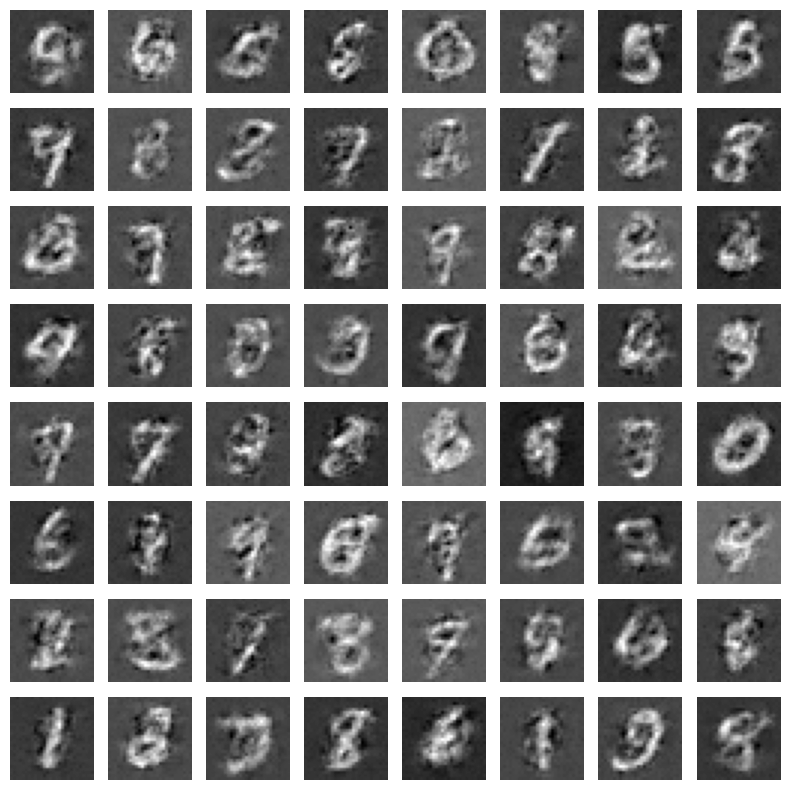

In [11]:
# Generate samples from the trained model using odeint from zuko
# The flow model returns the predicted flow, and to generate samples from it, we need to simulate the flow process. 
# This often involves integrating the flow backwards in time or solving the differential equation system.

@torch.no_grad()
def run_flow(flow_model, x_0, t_0, t_1, device='cpu'):
    def f(t: float, x):
        return flow_model(x, time=torch.full(x.shape[:1], t, device=device))

    # Ordinary differential equation (ODE) solver/integrator
    # Gives new new data distribution by evaluationg the solving function evaluated at time t_1
    return odeint(f, x_0, t_0, t_1, phi=flow_model.parameters())

# Generate samples
def generate_samples(flow_model, num_samples=64, input_dim=784, device='cpu'):
    flow_model.eval()
    t_0 = 0.0
    t_1 = 1.0
    x_0 = torch.randn(num_samples, input_dim, device=device)  # Start with noise

    x_1 = run_flow(flow_model, x_0, t_0, t_1, device=device)
    return x_1.view(-1, 1, 28, 28).cpu()

generated_samples = generate_samples(flow_model, num_samples=64, input_dim=n_features, device=device)

# Denormalize the images
denormalize = transforms.Compose([
    transforms.Normalize((0,), (2,)),  # Reverse the normalization step
    transforms.Normalize((-0.5,), (1.0,))
])

denorm_samples = [denormalize(sample) for sample in generated_samples]


# Visualize the generated samples
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(denorm_samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()